# Introduction

This is a simple illustration of op-sharded (SPMD) style model parallel training using PyTorch/XLA.
The implementation and core concepts here are from [NVIDIA/Megatron](https://github.com/NVIDIA/Megatron-LM)

The word SPMD stands from Single Program Multiple Data. The essence of this method of Model Parallelism is that sharding is done in such a way that each core executes program of identical shape. 

We illustrate SPMD training using a two layer network example for linear regression.
![](img/default-network.png) 
<img src="img/default-network.png" width="1000"  />

The two colors in each of the layers indicate how we are going to shard them.
Using ColumnParallelLinear and RowParallelLinear layers from Megatron's mpu module (refactored here to work with PyTorch/XLA)
![](img/mp-network.png)


Notice that f & g are conjugate functions. f is an identity function in the forward pass and an all reduce in the backward pass. g is all_reduce in the forward pass and identity in the backward pass.

With this setup in effect one replica of model is split into two:
  
![](img/sharded-replica.png)


For example if you are using 8 total cores (world size), model_parallel world_size will be 2 and you can have 4 data


## Setup
XRT_TPU_CONFIG
Defines where XRT Server will be running

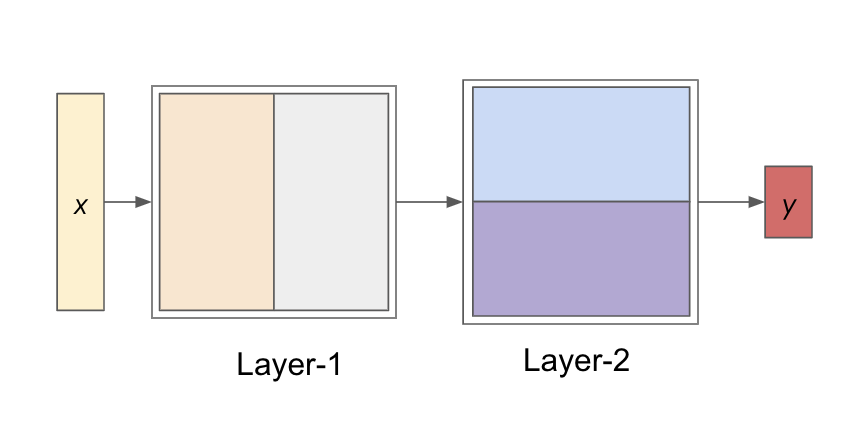

In [12]:
from IPython.display import Image, display
display(Image(filename='img/default-network.png', embed=True))

In [2]:
import os
os.environ['XRT_TPU_CONFIG'] = 'localservice;0;localhost:51011'

In [3]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch_xla.debug.metrics as met
from dataclasses import dataclass

from xla_add.mpu.layers import (
    ColumnParallelLinear,
    RowParallelLinear,
)

import xla_add.mpu as mpu
import xla_add.mpu.layers as layers

## Create dataset

Creating a simple linear dataset.

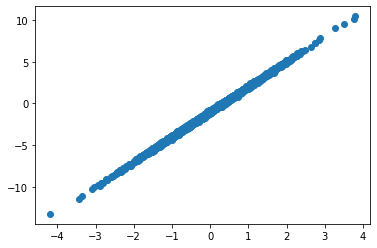

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

num_samples = 2048
input_dim = 1
xs = np.random.normal(size=(num_samples, input_dim))
noise = np.random.normal(scale=0.1, size=(num_samples,input_dim))
#ys = (xs**2) * 3 - 1 + noise
ys = xs * 3 - 1 + noise


plt.scatter(xs, ys)

inputs = torch.from_numpy(xs)
targets = torch.from_numpy(ys)
dataset = torch.utils.data.TensorDataset(inputs, targets)

## Define the Network
Notice that we use ColumnParallelLinear, and RowParallelLinear for consecutive layers.
For more insights on how to select these layers to replace your linear layer, please refer to [NVIDIA/Megatron](https://arxiv.org/pdf/1909.08053.pdf)

In [8]:
class sample_network(nn.Module):
    def __init__(self):
        super(sample_network, self).__init__()
        #self.linear1 = nn.Linear(64, 32)
        #self.linear2 = nn.Linear(32, 10)
        self.linear1 = ColumnParallelLinear(1, 32, gather_output=False, bias=False)
        self.linear2 = RowParallelLinear(32, 1, input_is_parallel=True, bias=False)
        self.nl = nn.ReLU()
        #self.out = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.nl(x)
        x = self.linear2(x)
        return x

# Define per core program

When running Model parallel training, pay attention to the distributed sampler and gradient all-reduce operation
The data parallel rank, world size and groups are not the default i.e. not the same as the default data parallel training. 

Please see the comments inline for concrete example:

In [9]:
def per_core_action(index):
    # MP Setup
    tensor_model_parallel_size = 2
    # This will initialize the variables for sharded layers to work correctly
    mpu.initialize_model_parallel(tensor_model_parallel_size)
    
    
    data_parallel_rank = mpu.initialize.get_data_parallel_rank()
    data_parallel_world_size = mpu.initialize.get_data_parallel_world_size()
    data_parallel_group = mpu.initialize.get_data_parallel_global_group()

    # XLA Device abstraction
    device = xm.xla_device()
    model = sample_network().to(device)

    # Notice the num_replica and rank parameters of the sampler
    # Data parallel rank of the two devices which are holding shards of the same replica will be same
    distributed_sampler = torch.utils.data.distributed.DistributedSampler(
          dataset,
          num_replicas=(xm.xrt_world_size() // tensor_model_parallel_size),
          rank=data_parallel_rank,
          shuffle=True)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=distributed_sampler)

    parallel_loader = pl.MpDeviceLoader(dataloader, device)

    optimizer = optim.SGD(model.parameters(), lr=0.00001)

    num_epochs = 10
    for e in range(num_epochs):
        for x, y in parallel_loader:
            y_hat = model(x)
            loss = torch.sum((y - y_hat)**2 / y.numel())
            # Optionally print graph of the forward pass to examine sharding
            #print(torch_xla._XLAC._get_xla_tensors_text([loss]))
            loss.backward()
            xm.optimizer_step(optimizer, groups=data_parallel_group)
            #print(f"Debug: Rank:{xm.get_ordinal()} DP Group:{data_parallel_group} loss :{loss}")
        xm.master_print(f"Epoch:{e}, loss :{loss}")
    
        
    

    #xm.rendezvous('All processes meet here!')


# Execute Training

In [10]:
%matplotlib inline
import torch_xla.distributed.xla_multiprocessing as xmp
xmp.spawn(per_core_action, nprocs=8, start_method='fork')

2021-10-21 00:41:10.453247: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TPURoundRobin" device_type: "CPU"') for unknown op: TPURoundRobin
2021-10-21 00:41:10.453308: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TpuHandleToProtoKey" device_type: "CPU"') for unknown op: TpuHandleToProtoKey


> initializing tensor model parallel with size 2
> initializing pipeline model parallel with size 1
>>>> _TENSOR_MODEL_PARALLEL_GROUP: [0, 1]


2021-10-21 00:41:34.862263: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TPURoundRobin" device_type: "CPU"') for unknown op: TPURoundRobin
2021-10-21 00:41:34.862331: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TpuHandleToProtoKey" device_type: "CPU"') for unknown op: TpuHandleToProtoKey
2021-10-21 00:41:34.971344: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TPURoundRobin" device_type: "CPU"') for unknown op: TPURoundRobin
2021-10-21 00:41:34.971407: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TpuHandleToProtoKey" device_type: "CPU"') for unknown op: TpuHandleToProtoKey
2021-10-21 00:41:36.561079: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TPURoundRobin" device_type: "CPU"') for unknown op: TPURoundRobin
2021-10-21 00:41:36.561141: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TpuHandleToProtoKey" device_type: "CPU"') for unknown op: TpuHandleToProtoKey
2021-10-21 00:41:36.78

Epoch:0, loss :9.13158130645752
Epoch:1, loss :8.9047212600708
Epoch:2, loss :8.521275520324707
Epoch:3, loss :7.9740891456604
Epoch:4, loss :7.249765872955322
Epoch:5, loss :6.334079742431641
Epoch:6, loss :5.220804214477539
Epoch:7, loss :3.940500497817993
Epoch:8, loss :2.6096081733703613
Epoch:9, loss :1.4902187585830688

2021-10-21 00:41:10.453247: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TPURoundRobin" device_type: "CPU"') for unknown op: TPURoundRobin
2021-10-21 00:41:10.453308: E tensorflow/core/framework/op_kernel.cc:1623] OpKernel ('op: "TpuHandleToProtoKey" device_type: "CPU"') for unknown op: TpuHandleToProtoKey
